In [1]:
import numpy

import constants
import rscha2d
import trig
import fibonacci_sphere
import coords

from matplotlib import pyplot

%matplotlib nbagg

In [2]:
lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
knots_bd = numpy.arange(-2100, 2050, 50)

In [3]:
theta_m, phi_m = fibonacci_sphere.grid(5000)
in_cap = trig.angulardist(theta_m, phi_m, theta_c, phi_c) < theta_0d
theta_m = theta_m[in_cap]; phi_m = phi_m[in_cap]

# theta_m, phi_m = model.theta_geo, model.phi_geo
r_m = numpy.ones_like(theta_m)*constants.a_r
times_dbd, r_dbd, theta_dbd, phi_dbd = coords.anything(r_m, theta_m, phi_m, knots_bd)
#times_d, r_d, theta_d, phi_d = coords.anything(r_m, theta_m, phi_m, knots_bd)

In [4]:
import importlib
importlib.reload(rscha2d)

model_bd = rscha2d.Model()
model_bd.set_model_params(theta_c, phi_c, theta_0d, 0.0, 3, 3, 2, knots=knots_bd,
                          #temporal_reg=3e-2, spatial_reg=0.8, g10_ref=-35)
                          temporal_reg=1e-2, spatial_reg=1e-4, g10_ref=-30)
                          #temporal_reg=1, spatial_reg=1e-4, g10_ref=-30)
model_bd.add_data("../data/rscha2d/bd_javi_21abril.dat")
#model_bd.add_data("../data/rscha2d/bd_syn_sha.dat")

In [5]:
g_bd = model_bd.solve()

[-2.08306728 -1.6027601  -1.11270774 ..., -0.03612319 -0.00666948
  0.01215455]


In [6]:
dt2 = numpy.zeros((2040, 2040))
ds = numpy.diff(numpy.eye(85), 2, axis=0)
ds = ds.T @ ds

In [7]:
ds

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [-2.,  5., -4., ...,  0.,  0.,  0.],
       [ 1., -4.,  6., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  6., -4.,  1.],
       [ 0.,  0.,  0., ..., -4.,  5., -2.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

In [8]:
for i in range(85):
    dt2[i*24:(i+1)*24, i*24:(i+1)*24] = ds[i, i]

In [9]:
numpy.savetxt("dt2.txt", dt2)

In [10]:
n_knots = 85
n_degrees = 24
a = numpy.ones((1, n_knots))
l = 0
P = numpy.zeros((n_degrees, n_degrees*n_knots))
for i in range(n_degrees):
    P[i, l:l+n_knots] = a
    l = l+n_knots

P = numpy.tile(P, (n_knots, 1))
    

In [11]:
numpy.savetxt("p.txt", P)

In [12]:
numpy.savetxt("dt2.txt", dt2)

In [13]:
numpy.savetxt("mf_2.txt", numpy.tile(numpy.atleast_2d(model_bd.reg_br2()).T, (85, 2040)) * model_bd.reg_dt2())

In [14]:
numpy.savetxt("adift.txt", model_bd.Adift_last_solved)
numpy.savetxt("d.txt", model_bd.data_last_solved)

In [15]:
model_bd.Adift_last_solved.shape

(6766, 2040)

In [16]:
dsl = model_bd.reg_dt2()

In [17]:
dsl

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

In [18]:
numpy.savetxt("ffff.txt", model_bd.Adift_last_solved[999, :])

In [19]:
D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                   model_bd.theta_geo, model_bd.phi_geo, g_bd)
D_rem_bd = trig.mindiff(D_rem_bd, 0)
I_rem_bd = trig.mindiff(I_rem_bd, 0)

D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]

I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]

In [20]:
import rscha_r; importlib.reload(rscha_r)

rscha_r.rscha_condition_matrix_dif((model_bd.k_int,
                                                model_bd.m_int,
                                                model_bd.n_int),
                                               (model_bd.k_ext,
                                                model_bd.m_ext,
                                                model_bd.n_ext),
                                               model_bd.m_mehler,
                                               numpy.atleast_1d(constants.a_r), numpy.atleast_1d(numpy.deg2rad(10)), 
                                               numpy.atleast_1d(0),
                                               model_bd.theta_0p,
                                               model_bd.Bx_dip_r, model_bd.By_dip_r, model_bd.Bz_dip_r,
                                            model_bd.F_dip_avg)

(array([[  4.55925474e-15,  -1.06838448e-01,  -1.40733161e-02, ...,
          -9.99093483e-02,  -8.15075682e-01,  -9.32159416e-02],
        [  3.15209599e-15,  -7.38640546e-02,   1.08547117e-01, ...,
           7.70598176e-01,  -5.63512444e-01,   7.18972106e-01],
        [  3.15209599e-15,  -7.38640546e-02,   1.08547117e-01, ...,
           7.70598176e-01,  -5.63512444e-01,   7.18972106e-01],
        ..., 
        [ -2.71886922e-15,   6.37121159e-02,  -8.93179478e-02, ...,
          -6.34086373e-01,   4.86062813e-01,  -5.91605884e-01],
        [ -2.71886922e-15,   6.37121159e-02,  -8.93179478e-02, ...,
          -6.34086373e-01,   4.86062813e-01,  -5.91605884e-01],
        [  2.25554852e-15,  -5.28549765e-02,  -8.71548110e-02, ...,
          -6.18729823e-01,  -4.03233171e-01,  -5.77278143e-01]]),
 array([[-0.01046341, -0.02836268,  0.05193223, ...,  0.36867749,
         -0.03938859,  0.34397802],
        [-0.00827441,  0.01664796,  0.03155121, ...,  0.22398851,
          0.26697206,  0

In [21]:
out_D = (numpy.abs(trig.mindiff(D_rem_bd, model_bd.D_o)) > 3*numpy.std(D_res_bd))
out_I = (numpy.abs(trig.mindiff(I_rem_bd, model_bd.I_o)) > 3*numpy.std(I_res_bd))
out_F = (numpy.abs(F_rem_bd - model_bd.F_o) > 2*numpy.std(F_res_bd))

inliers = ~(out_D | out_I | out_F)
print(f"{(out_D | out_I | out_F).sum()} datos filtrados")

162 datos filtrados


In [22]:
#with open("../data/rscha2d/bd_javi_21abril_fil.dat", "w") as f:
#    for i, line in enumerate(open("../data/rscha2d/bd_javi_21abril.dat", "r")):
#        if i in model_bd.ids[inliers]:
#            f.write(line)

In [23]:
#model_bd.add_data("../data/rscha2d/bd_javi_21abril.dat")

In [24]:
#g_bd = model_bd.solve()

In [25]:
D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                   model_bd.theta_geo, model_bd.phi_geo, g_bd)
D_rem_bd = trig.mindiff(D_rem_bd, 0)
I_rem_bd = trig.mindiff(I_rem_bd, 0)

D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]

I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]

<IPython.core.display.Javascript object>


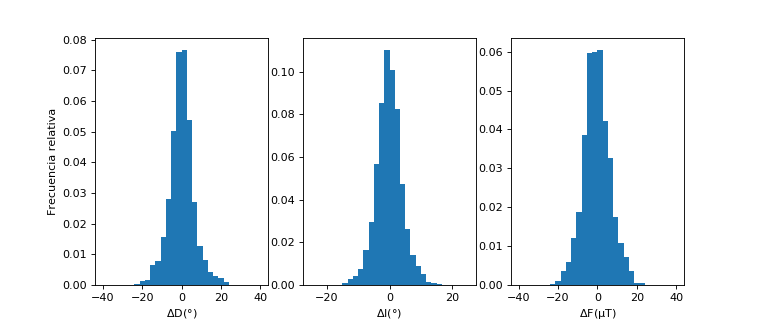

In [28]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(9.5, 4))

axes[0].hist(numpy.rad2deg(D_res_bd), color="C0",
             label="residuos (bd)", range=(-40, 40), normed=True, bins=30)
axes[0].set_xlabel("$\Delta $D(°)")

axes[1].hist(numpy.rad2deg(I_res_bd), color="C0",
             label="residuos (bd)", range=(-25, 25), normed=True, bins=30)
axes[1].set_xlabel("$\Delta $I(°)")

axes[2].hist(F_res_bd, color="C0",
             label="residuos (bd)", range=(-40, 40), normed=True, bins=30)
axes[2].set_xlabel("$\Delta $F(μT)")

axes[0].set_ylabel("Frecuencia relativa")

pyplot.show(fig)
#fig.savefig("../data/rscha2d/distribucion.png", frameon=True)

In [29]:
t_cur = numpy.linspace(-2000, 2000, 400)
name_at = "Madrid"
theta_at, phi_at = numpy.deg2rad((90 - 40.423, -3.7))
near = trig.angulardist(theta_at, phi_at, model_bd.thetav, model_bd.phiv) < 0.2

t_cur, r_cur, theta_cur, phi_cur = coords.curve_at(t_cur, constants.a_r, theta_at, phi_at)
D_cur_bd, I_cur_bd, F_cur_bd = model_bd.synth_data(t_cur, r_cur, theta_cur, phi_cur, g_bd)
D_cur_bd = trig.mindiff(D_cur_bd, 0)
I_cur_bd = trig.mindiff(I_cur_bd, 0)

In [30]:
import geofield
import xyzfield

sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

D_shadif = numpy.empty_like(sha.years)
I_shadif = numpy.empty_like(sha.years)
F_shadif = numpy.empty_like(sha.years)

years = numpy.array(sha.years)

for i, y in enumerate(sha.years):
    dec,inc,f,h = xyzfield.xyz2difh(*xyzfield.xyzfieldv2(sha.gcomp[i, :],
                                                         numpy.atleast_1d(phi_at),
                                                         numpy.atleast_1d(theta_at)))
    D_shadif[i] = dec
    I_shadif[i] = inc
    F_shadif[i] = f
    
D_shadif, I_shadif = numpy.rad2deg((D_shadif, I_shadif))

<IPython.core.display.Javascript object>


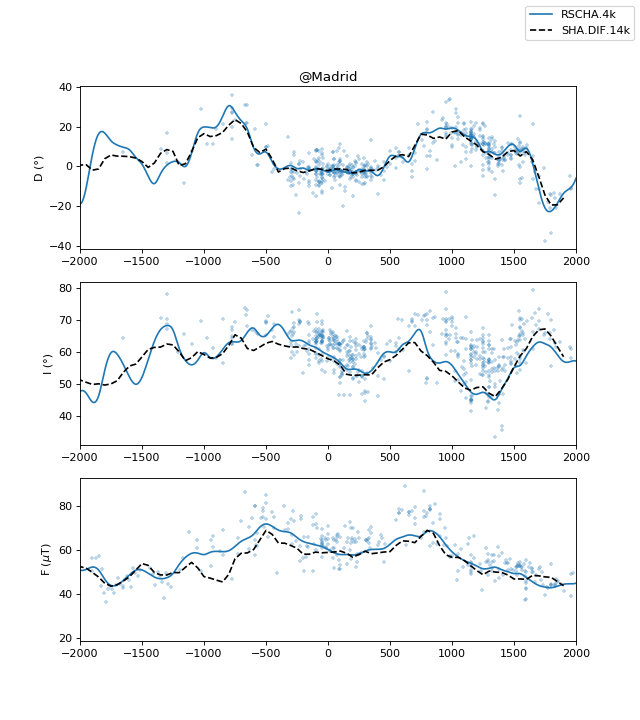

In [31]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(8,9))

common={"marker" : "+", "s" : 8, "alpha" : 0.3}

ax0.plot(t_cur, numpy.rad2deg(D_cur_bd), label="RSCHA.4k")
ax0.plot(years, D_shadif, "k--", label="SHA.DIF.14k")
ax0.scatter(model_bd.tv[near], numpy.rad2deg(model_bd.D_o[near]), **common)
ax0.set_ylabel("D (°)")

ax1.plot(t_cur, numpy.rad2deg(I_cur_bd))
ax1.plot(years, I_shadif, "k--")
ax1.scatter(model_bd.tv[near], numpy.rad2deg(model_bd.I_o[near]), **common)
ax1.set_ylabel("I (°)")

ax2.plot(t_cur, F_cur_bd)
ax2.plot(years, F_shadif, "k--")
ax2.scatter(model_bd.tv[near], model_bd.F_o[near], **common)
ax2.set_ylabel("F ($\mu $T)")

ax0.set_title("@{}".format(name_at))

for ax in (ax0, ax1, ax2):
    ax.set_xbound(-2000, 2000)
    
fig.legend(*ax0.get_legend_handles_labels())

In [ ]:
3*numpy.average(model_bd.F_err[~numpy.isnan(model_bd.F_err)])

In [ ]:
model_bd.reg_br2()

In [ ]:
1/(1-numpy.cos(model_bd.theta_0p))*5

In [ ]:
model_bd.tv

In [ ]:
g = numpy.arange(24)
g = numpy.repeat(g, 85)

In [ ]:
numpy.concatenate(g.reshape(24,85).T)